<a href="https://colab.research.google.com/github/navneetkrc/Recommender_systems/blob/master/Movie_Recommender/Content%20Based%20Movie%20Recommender/3_Keyword_based_Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Keyword Movie Recommender

based on [this github](https://github.com/gblinick/Movie-Recommender-with-NLP/blob/master/Keyword%20Movie%20Recommender.ipynb)

---



##Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##Download dataset movies csv file


In [0]:
#!wget https://github.com/navneetkrc/Recommender_systems/blob/master/Movie_Recommender/Content%20Based%20Movie%20Recommender/movies0.csv

In [6]:
movies = pd.read_csv('movies0.csv',error_bad_lines=False, header=0)
movies.head()

,tconst,primaryTitle,startYear,runtimeMinutes,genres,directors,writers,averageRating,numVotes,plot,plot outlines,keywords,synopsis
0,tt0111161,The Shawshank Redemption,1994,142,Drama,nm0001104,"nm0000175,nm0001104",9.3,2057323,Two imprisoned men bond over a number of years...,Chronicles the experiences of a formerly succe...,"wrongful-imprisonment,escape-from-prison,based...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,tt0468569,The Dark Knight,2008,152,"Action,Crime,Drama",nm0634240,"nm0634300,nm0634240,nm0333060,nm0004170",9.0,2023734,When the menace known as the Joker emerges fro...,Set within a year after the events of Batman B...,"dc-comics,moral-dilemma,psychopath,clown,scarr...",The movie begins with a gang of men with clown...
2,tt1375666,Inception,2010,148,"Action,Adventure,Sci-Fi",nm0634240,nm0634240,8.8,1802989,A thief who steals corporate secrets through t...,"Dom Cobb is a skilled thief, the absolute best...","dream,subconscious,ambiguous-ending,thief,psyc...","A young man, exhausted and delirious, washes u..."
3,tt0137523,Fight Club,1999,139,Drama,nm0000399,"nm0657333,nm0880243",8.8,1646400,An insomniac office worker and a devil-may-car...,A nameless first person narrator (Edward Norto...,"surprise-ending,fighting,multiple-personality-...",We back out of the webbing of neurons and brai...
4,tt0110912,Pulp Fiction,1994,154,"Crime,Drama",nm0000233,"nm0000233,nm0000812",8.9,1607874,"The lives of two mob hitmen, a boxer, a gangst...",Jules Winnfield (Samuel L. Jackson) and Vincen...,"nonlinear-timeline,black-comedy,overdose,bonda...","Late one morning in the Hawthorne Grill, a res..."


## Keyword EDA

In [0]:
movies = movies[movies.keywords.notnull()]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

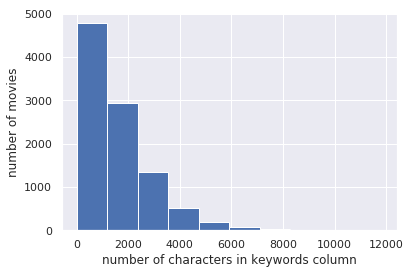

In [9]:
number_of_keyword_chars = []
for keywords in movies['keywords']:#[:10000]:
    n_chars = len(keywords)
    number_of_keyword_chars.append(n_chars)


plt.hist(number_of_keyword_chars)
plt.xlabel('number of characters in keywords column')
plt.ylabel('number of movies')
plt.show()

In [10]:
print("keywords: %.3f" %(np.mean(movies['keywords'].str.len())) )

keywords: 1585.197


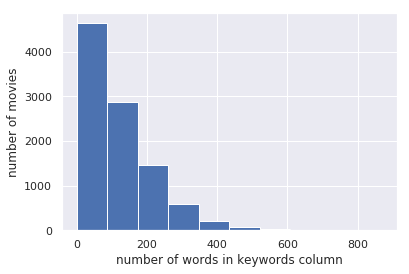

In [11]:
number_of_keywords = []
for keywords in movies['keywords']:
    n_keywords = len(keywords.split(','))
    number_of_keywords.append(n_keywords)

plt.hist(number_of_keywords)
plt.xlabel('number of words in keywords column')
plt.ylabel('number of movies')
plt.show()

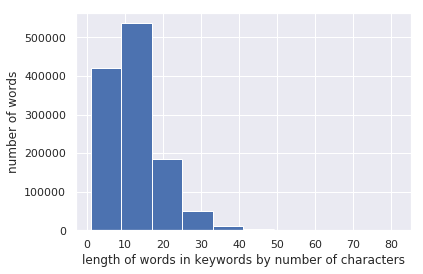

In [12]:
keyword_lengths = []
for keywords in movies['keywords']:
    keywords = keywords.split(',')
    for keyword in keywords:
        keyword_lengths.append(len(keyword))
        
plt.hist(keyword_lengths)
plt.xlabel('length of words in keywords by number of characters')
plt.ylabel('number of words')
plt.show()

## Modelling

In [0]:
# Import movies table and set the index
#movies = pd.read_csv('Blog Post/movies_keywords.csv')

In [0]:
movies.reset_index(inplace=True)
movies = movies[['primaryTitle', 'keywords']]

In [0]:
# Processing Keywords
keywords = movies['keywords'].tolist()

from nltk.tokenize import word_tokenize
keywords = [word_tokenize(keyword.lower()) for keyword in keywords]

def no_commas(doc):
    no_commas = [t for t in doc if t!=',']
    return(no_commas)

keywords = [no_commas(kw) for kw in keywords]
processed_keywords = keywords

In [0]:
#To save processed keywords
# import csv
# with open('Data/processed_keywords.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(processed_keywords)
# csvFile.close()

In [0]:
# To import processed keywords
# with open('Data/processed_keywords.csv', 'r') as f:
#     reader = csv.reader(f)
#     processed_keywords = list(reader)
# processed_keywords = processed_keywords[0::2] # get rid of empty lists

### 1st Mode: tf-idf with cosine similarity

In [18]:
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(processed_keywords) # create a dictionary of words from our keywords

corpus = [dictionary.doc2bow(doc) for doc in processed_keywords] 
#create corpus where the corpus is a bag of words for each document

from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(corpus) #create tfidf model of the corpus

from gensim.similarities import MatrixSimilarity
# Create the similarity data structure. This is the most important part where we get the similarities between the movies.
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
def movie_recommendation(movie_title, number_of_hits=5):
    movie = movies.loc[movies.primaryTitle==movie_title] # get the movie row
    keywords = movie['keywords'].iloc[0].split(',') #get the keywords as a Series (movie['keywords']),
    # get just the keywords string ([0]), and then convert to a list of keywords (.split(',') )
    query_doc = keywords #set the query_doc to the list of keywords
    
    query_doc_bow = dictionary.doc2bow(query_doc) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the movie ID and it's tf-idf value for the movie

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our movie and every other movie. 
    #So the length is the number of movies we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=movies.primaryTitle.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[1:number_of_hits+1] 
    #get the top matching results, i.e. most similar movies; start from index 1 because every movie is most similar to itself

    #print the words with the highest tf-idf values for the provided movie:
    sorted_tfidf_weights = sorted(tfidf[corpus[movie.index.values.tolist()[0]]], key=lambda w: w[1], reverse=True)
    print('The top 5 words associated with this movie by tf-idf are: ')
    for term_id, weight in sorted_tfidf_weights[:5]:
        print(" '%s' with a tf-idf score of %.3f" %(dictionary.get(term_id), weight))
    
    # Print the top matching movies
    print("Our top %s most similar movies for movie %s are:" %(number_of_hits, movie_title))
    for idx, (movie,score) in enumerate(zip(top_hits.index, top_hits)):
        print("%d %s with a similarity score of %.3f" %(idx+1, movie, score))

In [20]:
movie_recommendation('The Shawshank Redemption', 5)

The top 5 words associated with this movie by tf-idf are: 
 'boom-shot' with a tf-idf score of 0.092
 'fresh-fish' with a tf-idf score of 0.092
 'killed-by-prison-guard' with a tf-idf score of 0.092
 'library-cart' with a tf-idf score of 0.092
 'missing-prisoner' with a tf-idf score of 0.092
Our top 5 most similar movies for movie The Shawshank Redemption are:
1 Stir Crazy with a similarity score of 0.067
2 Escape from Alcatraz with a similarity score of 0.067
3 Lock Up with a similarity score of 0.066
4 The Last Castle with a similarity score of 0.064
5 Anything for Her with a similarity score of 0.059


In [0]:
def keywords_recommendation(keywords, number_of_hits):
    query_doc_bow = dictionary.doc2bow(keywords) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the movie ID and it's tf-idf value for the movie

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our movie and every other movie. 
    #So the length is the number of movies we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=movies.primaryTitle.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[:number_of_hits] #get the top matching results, 
    # i.e. most similar movies

    # Print the top matching movies
    print("Our top %s most similar movies for the keywords %s are:" %(number_of_hits, keywords))
    for idx, (movie,score) in enumerate(zip(top_hits.index, top_hits)):
        print("%d '%s' with a similarity score of %.3f" %(idx+1, movie, score))

In [22]:
keywords_recommendation(['wrongful-imprisonment','escape-from-prison','based-on-the-works-of-stephen-king',
                         'prison', 'voice-over-narration', 'caged-bird','reference-to-fort-hancock-texas','aria'], 5)

Our top 5 most similar movies for the keywords ['wrongful-imprisonment', 'escape-from-prison', 'based-on-the-works-of-stephen-king', 'prison', 'voice-over-narration', 'caged-bird', 'reference-to-fort-hancock-texas', 'aria'] are:
1 'The Shawshank Redemption' with a similarity score of 0.164
2 'Down by Law' with a similarity score of 0.150
3 'Old Men in New Cars: In China They Eat Dogs II' with a similarity score of 0.093
4 'Diva' with a similarity score of 0.093
5 'I Am a Fugitive from a Chain Gang' with a similarity score of 0.088


### 2nd Model: Word counts with cosine similarity

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
def get_vectors(text):
    vectorizer = CountVectorizer(text)
    X = vectorizer.fit_transform(text).toarray()
    return(X)
vectors = get_vectors(movies.keywords.tolist())

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_recommender(movie_title, number_of_hits=5):
    movie_index = movies[movies.primaryTitle == movie_title].index.values[0]

    cosines = []
    for i in range(len(vectors)):
        vector_list = [vectors[movie_index], vectors[i]]
        cosines.append(cosine_similarity(vector_list)[0,1])

    cosines = pd.Series(cosines)
    index = cosines.nlargest(number_of_hits+1).index

    matches = movies.loc[index]
    for match,score in zip(matches['primaryTitle'][1:],cosines[index][1:]):
        print(match,score )

In [25]:
cosine_recommender('The Shawshank Redemption')

Kill Your Friends 0.7411855258460268
The Riot Club 0.7308165808051436
Side Effects 0.7277681291363095
Going Clear: Scientology & the Prison of Belief 0.7273396914436095
Hot Summer Nights 0.7272736609097773


### 3rd Model: Jaccard Similarity

In [0]:
def get_jaccard_sim(str1, str2):
    a = set(str1.split(','))
    b = set(str2.split(','))
    c = a.intersection(b)
    return(float(len(c)) / (len(a) + len(b) - len(c)))

def jaccard_recommender(movie_title, number_of_hits=5):
    movie = movies[movies.primaryTitle==movie_title]
    keyword_string = movie.keywords.iloc[0]

    jaccards = []
    for movie in movies['keywords']:
        jaccards.append(get_jaccard_sim(keyword_string, movie))
    jaccards = pd.Series(jaccards)
    jaccards_index = jaccards.nlargest(number_of_hits+1).index
    matches = movies.loc[jaccards_index]
    for match,score in zip(matches['primaryTitle'][1:],jaccards[jaccards_index][1:]) :
        print(match,score )

In [27]:
jaccard_recommender('The Shawshank Redemption')

Lock Up 0.07127882599580712
The Getaway 0.064
Boy A 0.0631768953068592
Character 0.06126482213438735
Call Northside 777 0.060674157303370786
